# Imports

In [1]:
import rasterio
import geopandas as gpd
from rasterio.features import rasterize
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

In [4]:
def read_and_rasterize_image(tif_path, shape_file_path):
    with rasterio.open(tif_path) as src:
        image = src.read([1, 2, 3])  # Reading the first three bands (assuming RGB)
        transform = src.transform

    # Read the shapefile
    shapes = gpd.read_file(shape_file_path)

    # Rasterize the shapefile to create a mask
    mask = rasterize(
        [(shape, 1) for shape in shapes.geometry],
        out_shape=image[0].shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )
    

    # Normalize the image
    image = image / 255.0
    return image.transpose((1, 2, 0)), mask

In [5]:
def divide_into_patches(image, mask, patch_size):
    """
    Divides an image and its mask into smaller patches.

    Parameters:
    - image: The image to be divided (numpy array).
    - mask: The corresponding mask for the image (numpy array).
    - patch_size: The size of each patch (tuple of two integers).

    Returns:
    - image_patches: A list of image patches.
    - mask_patches: A list of mask patches.
    """
    # Ensure the input dimensions are compatible
    assert image.shape[0:2] == mask.shape[0:2], "Image and mask must have the same dimensions"
    
    # Calculate the number of patches along each dimension
    patches_along_height = image.shape[0] // patch_size[0]
    patches_along_width = image.shape[1] // patch_size[1]

    image_patches = []
    mask_patches = []

    for i in range(patches_along_height):
        for j in range(patches_along_width):
            # Calculate patch coordinates
            start_row = i * patch_size[0]
            end_row = start_row + patch_size[0]
            start_col = j * patch_size[1]
            end_col = start_col + patch_size[1]

            # Extract patches
            image_patch = image[start_row:end_row, start_col:end_col]
            mask_patch = mask[start_row:end_row, start_col:end_col]

            image_patches.append(image_patch)
            mask_patches.append(mask_patch)

    return np.array(image_patches), np.array(mask_patches)

In [6]:
file_names = ["2022_131000_456000_RGB_hrl", "2022_133000_456000_RGB_hrl"], "2022_136000_457000_RGB_hrl", "2022_129000_458000_RGB_hrl", "2022_131000_455000_RGB_hrl"]

In [7]:
patch_size = (512, 512)

In [8]:
folds = {}

for i, file_name in enumerate(file_names):
    mask_path = f"masks/{file_name}.gpkg"
    tif_path = f"nl_8cm/{file_name}.tif"
    image, mask = read_and_rasterize_image(tif_path, mask_path)
    image, mask = divide_into_patches(image=image, mask=mask, patch_size=patch_size)
    folds[i] = {"images": image, "masks": mask}

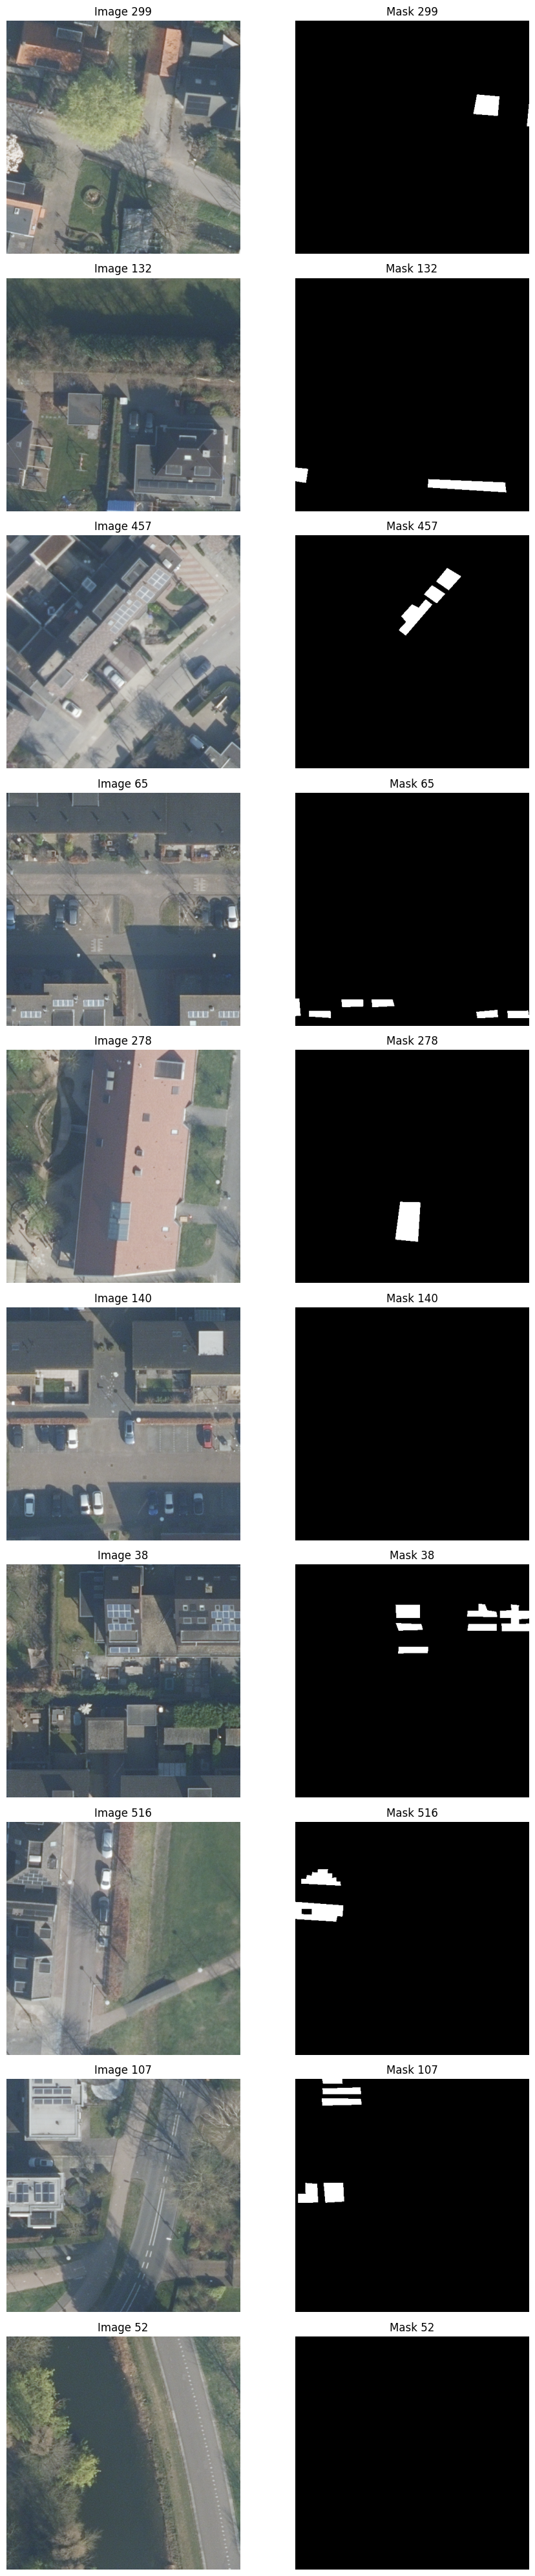

In [9]:
fold = 0

num_images = len(folds[fold]['images'])
indices = np.random.choice(range(num_images), size=10, replace=False)

# Set up the matplotlib figure and axes
fig, axs = plt.subplots(10, 2, figsize=(10, 40))  # Adjust figsize as needed

for i, idx in enumerate(indices):
    image = folds[fold]["images"][idx] # Load the image
    mask = folds[fold]["masks"][idx]  # Load the corresponding mask

    axs[i, 0].imshow(image, cmap='gray')
    axs[i, 0].axis('off')  # Remove axis ticks and labels
    axs[i, 0].set_title(f"Image {idx}")

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"Mask {idx}")

plt.tight_layout()
plt.show()

In [ ]:
train_folds = [0, 1, 2, 3]
test_fold = 4

X_train = np.concatenate([folds[i]['images'] for i in train_folds], axis=0)
y_train = np.concatenate([folds[i]['masks'] for i in train_folds], axis=0)
X_test, y_test = folds[test_fold]['images'], folds[test_fold]['masks']

In [19]:
X_train.shape

(5, 512, 512, 3)

In [20]:
y_train.shape

(5, 512, 512)

In [21]:
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x

def downsample_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def upsample_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    s1, p1 = downsample_block(inputs, 64)
    s2, p2 = downsample_block(p1, 128)
    s3, p3 = downsample_block(p2, 256)

    b = conv_block(p3, 512)

    d1 = upsample_block(b, s3, 256)
    d2 = upsample_block(d1, s2, 128)
    d3 = upsample_block(d2, s1, 64)

    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d3)

    model = models.Model(inputs, outputs, name="U-Net")
    return model


model = build_unet(input_shape=(patch_size[0], patch_size[1], 3))

In [22]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.BinaryCrossentropy(), 
              metrics=[metrics.BinaryAccuracy()])
# Vervang met iou

In [23]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="model.keras",
    save_weights_only=False,  # Set to True to save only weights, False to save the whole model
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)  # Log a message whenever the model is saved

In [ ]:
# Now, include this callback in your model.fit() call
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.25, # Should be a individual fold
    callbacks=[model_checkpoint_callback],  # Include the callback here
    verbose=1)

In [ ]:
# Extracting the history of training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extracting the history of training and validation accuracy
# Note: Replace 'accuracy' with 'acc' if your Keras version uses 'acc' instead
accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

# Setting up the subplot for loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Setting up the subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Load the saved model from the file
model = load_model('model.keras')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

id_ = random.randint(0, X_test.shape[0])

ax[0].imshow(X_test[id_], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y_test[id_], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(y_pred[id_], cmap='gray')
ax[2].set_title('Pred')
plt.show()